In [1]:
import pathlib
import pandas as pd
import numpy as np
import re
from plotnine import *
import scipy
from tqdm import tqdm
import time
from sklearn.mixture import GaussianMixture

In [2]:
# CLean
locationUsersFile=pathlib.Path(r'purchase_play.csv')
steam_clean = pd.read_csv(locationUsersFile, header=1, names=['user', 'game', 'hrs', 'purchase','play'])

In [3]:
# Train
locationUsersFile_train=pathlib.Path(r'user_train.csv')
steam_traind = pd.read_csv(locationUsersFile_train, header=1, names=['user', 'game', 'hrs', 'purchase','play'])

In [7]:
# Test
locationUsersFile_test=pathlib.Path(r'user_test.csv')
steam_test = pd.read_csv(locationUsersFile_test, header=1, names=['user', 'game', 'hrs', 'purchase','play'])

In [8]:
# Getting game grequency and also the top 20 of them 
game_freq = steam_traind.groupby(by='game').agg({'user': 'count', 'hrs': 'sum'}).reset_index()
top20 = game_freq.sort_values(by='user',ascending=False)[:20].reset_index()

In [9]:
print(top20)

    index                                          game  user       hrs
0    1267                                        Dota 2  3842  764598.1
1    4052                               Team Fortress 2  1855  138615.7
2    4553                                      Unturned  1246   13302.3
3     923               Counter-Strike Global Offensive  1103  255609.4
4    1966                        Half-Life 2 Lost Coast   795     122.6
5    2346                                 Left 4 Dead 2   770   27616.2
6     926                         Counter-Strike Source   766   74248.5
7    4661                                      Warframe   683   22638.0
8     920                                Counter-Strike   674  101049.6
9    1963                        Half-Life 2 Deathmatch   668    3462.7
10   1795                                   Garry's Mod   589   39938.3
11   4152                    The Elder Scrolls V Skyrim   580   57653.2
12    921                 Counter-Strike Condition Zero   563   

In [10]:
# Making the id integer type
steam_traind['user']=steam_traind['user'].astype(int)
steam_clean['user']=steam_clean['user'].astype(int)
steam_test['user']=steam_test['user'].astype(int)

In [11]:
# Removing some special characters in the game title
# Also removing the spaces
steam_traind['game1'] = steam_traind['game'].apply(lambda x: re.sub('[^a-zA-Z0-9]', '', x))
steam_clean['game1'] = steam_clean['game'].apply(lambda x: re.sub('[^a-zA-Z0-9]', '', x))

In [13]:
steam_clean.head()

,user,game,hrs,purchase,play,game1
0,5250,Cities Skylines,144.0,1,1,CitiesSkylines
1,5250,Counter-Strike,0.0,1,0,CounterStrike
2,5250,Counter-Strike Source,0.0,1,0,CounterStrikeSource
3,5250,Day of Defeat,0.0,1,0,DayofDefeat
4,5250,Deathmatch Classic,0.0,1,0,DeathmatchClassic


C:\Users\shrey\Anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
C:\Users\shrey\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


 lambda: [0.19895137 0.27721863 0.27805331 0.16878871 0.07698798]
 mean: [[1.48306449]
 [2.55784472]
 [4.50596474]
 [6.43185461]
 [7.41244698]]
 sigma: [[[0.15701571]]

 [[0.69240765]]

 [[1.00144721]]

 [[0.6707458 ]]

 [[0.34061901]]]



C:\Users\shrey\Anaconda3\lib\site-packages\plotnine\positions\position.py:204: PlotnineWarning: position_dodge requires non-overlapping x intervals


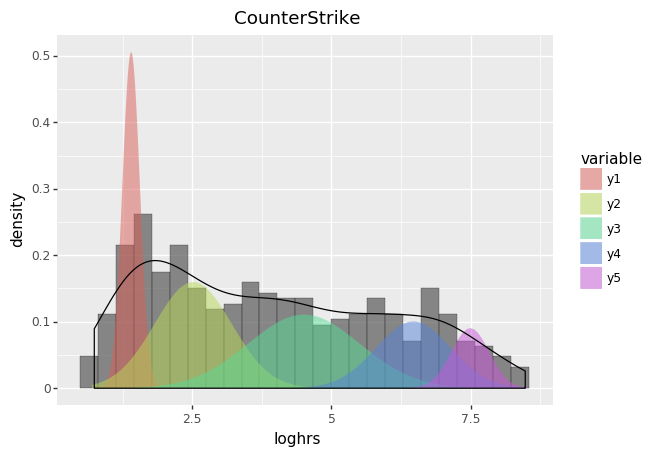

<ggplot: (-9223371946118663184)>


In [38]:
# Implementation of the EM algorithm 
def game_hrs_density(GAME, nclass, print_vals=True):
    #Ignore the game hrs less than 2 hrs
    game_data = steam_clean[(steam_clean['game1'] == GAME)&(steam_clean['hrs']>2)]
    #Log hrs
    game_data['loghrs'] = np.log(steam_clean['hrs'])
    #Calculate the mu,sigma to process Gaussian function
    mu_init = np.linspace(min(game_data['loghrs']), max(game_data['loghrs']), nclass).reshape(-1, 1)
    sigma_init = np.array([1] * nclass).reshape(-1, 1, 1)
    gaussian = GaussianMixture(n_components=nclass, means_init=mu_init, precisions_init=sigma_init).fit(game_data['loghrs'].values.reshape([-1, 1]))
    #print Gaussian Lambda Mean Sigma
    if print_vals:
        print(' lambda: {}\n mean: {}\n sigma: {}\n'.format(gaussian.weights_, gaussian.means_, gaussian.covariances_))
    #Random Generate
    x = np.linspace(min(game_data['loghrs']), max(game_data['loghrs']), 1000)
    #Plot
    dens = pd.DataFrame({'x': x})
    for i in range(nclass):
        dens['y{}'.format(i+1)] = gaussian.weights_[i]* scipy.stats.norm(gaussian.means_[i][0], gaussian.covariances_[i][0][0]).pdf(x)
    dens = dens.melt('x', value_name='gaussian')
    # Building data frame for plotting
    game_plt = ggplot(aes(x='loghrs', y='stat(density)'), game_data) + geom_histogram(bins=25, colour = "black", alpha = 0.7, size = 0.1) + \
               geom_area(dens, aes(x='x', y='gaussian', fill = 'variable'), alpha = 0.5, position = position_dodge(width=0.2)) + geom_density()+ \
               ggtitle(GAME)
    return game_plt
#Print one example
a = game_hrs_density('CounterStrike', 5, True)
print(a)

In [15]:
# Now creating a user item matrix
np.random.seed(910)
# Delete unnecessary characters
game_freq['game1'] = game_freq['game'].apply(lambda x: re.sub('[^a-zA-Z0-9]', '', x))
# Only Consider the games have more than 50 users
game_users = game_freq[game_freq['user'] > 50]

In [16]:
# Now applying to whole dataset
#For whole dataset
steam_clean_pos = steam_clean[steam_clean['hrs'] > 2]
steam_clean_pos_idx = steam_clean_pos['game1'].apply(lambda x: x in game_users['game1'].values)
steam_clean_pos = steam_clean_pos[steam_clean_pos_idx]
steam_clean_pos['loghrs'] = np.log(steam_clean_pos['hrs'])

In [17]:
# Defining the matrix
games = pd.DataFrame({'game1': sorted(steam_clean_pos['game1'].unique()), 'game_id': range(len(steam_clean_pos['game1'].unique()))})
users = pd.DataFrame({'user': sorted(steam_clean_pos['user'].unique()), 'user_id': range(len(steam_clean_pos['user'].unique()))})
steam_clean_pos = pd.merge(steam_clean_pos, games, on=['game1'])
steam_clean_pos = pd.merge(steam_clean_pos, users, on=['user'])

In [18]:
ui_mat = np.zeros([len(users), len(games)])
for i in range(steam_clean_pos.shape[0]):
    line = steam_clean_pos.iloc[i]
    ui_mat[line['user_id'], line['game_id']] = line['loghrs']

In [19]:
# dataset ready for test 
users_test = pd.DataFrame({'user': sorted(steam_test['user'].unique()), 'user_id': range(len(steam_test['user'].unique()))})
print(users_test)

           user  user_id
0          5250        0
1         76767        1
2         86540        2
3        103360        3
4        181212        4
...         ...      ...
5784  309058572     5784
5785  309255941     5785
5786  309262440     5786
5787  309265377     5787
5788  309404240     5788

[5789 rows x 2 columns]


In [20]:
# NOw do the same procedure on the training set 
# Only consider the games hrs more than 2 hrs
steam_train = steam_traind[steam_traind['hrs'] > 2]
#print(steam_train)
#Not consider the games that users less than 50

steam_train_idx = steam_train['game1'].apply(lambda x: x in game_users['game1'].values)
steam_train = steam_train[steam_train_idx]
steam_train['loghrs'] = np.log(steam_train['hrs'])

# Make Matrix
# List the games in train dataset use for recommend
games_train = pd.DataFrame({'game1': sorted(steam_train['game1'].unique()), 'game_id': range(len(steam_train['game1'].unique()))})
# List the users in train dataset use for recommend
users_train = pd.DataFrame({'user': sorted(steam_train['user'].unique()), 'user_id': range(len(steam_train['user'].unique()
                                                                                              ))})
#Merge the games and users to one data frame
steam_train = pd.merge(steam_train, games_train, on=['game1'])
steam_train = pd.merge(steam_train, users_train, on=['user'])

In [21]:
# Create training set
test=steam_train
ui_train = ui_mat
for i in range(test.shape[0]):
    line = test.iloc[i]
    ui_train[line['user_id'], line['game_id']] = 0
print("Dimensions of training user-item matrix:", ui_train.shape)

Dimensions of training user-item matrix: (8119, 404)


In [22]:
# RMSE for SVD evaulation 
def rmse(pred, test, data_frame=False):
    test_pred = np.array([np.nan] * len(test))
    for i in range(len(test)):
        line = test.iloc[i]
        test_pred[i] = pred[line['user_id'], line['game_id']]
    if data_frame:
        return pd.DataFrame({'test_pred': test_pred, 'loghrs': test['loghrs']})
    return np.sqrt(1/(len(test)-1)*np.sum((test_pred - test['loghrs']) ** 2))

In [23]:
# Basic svd
Y = pd.DataFrame(ui_train).copy()

In [24]:
# Apply imputation 
means = np.mean(Y)
for i, col in enumerate(Y.columns):
    Y[col] = Y[col].apply(lambda x: means[i] if x == 0 else x)
U, D, V = np.linalg.svd(Y)
p_df = pd.DataFrame({'x': range(1, len(D)+1), 'y': D/np.sum(D)})

In [25]:
#Set the latent factor as 60
lc = 60
pred = np.dot(np.dot(U[:, :lc], np.diag(D[:lc])), V[:lc, :])
#Calculate rmse
print(rmse(pred, test))
rmse(pred, test, True).head()

3.151236773716947


,test_pred,loghrs
0,0.033586,4.969813
1,0.035915,4.127134
2,0.110360,2.610070
3,0.083582,2.054124
4,0.490625,2.631889


In [26]:
#SVD via gradient descent
#Set the latent factor as 60
leading_components=60

In [27]:
# Setting matricies
Y = pd.DataFrame(ui_train)
I = Y.copy()

In [28]:
for col in I.columns:
    I[col] = I[col].apply(lambda x: 1 if x > 0 else 0)
U = np.random.normal(0, 0.01, [I.shape[0], leading_components])
V = np.random.normal(0, 0.01, [I.shape[1], leading_components])
#Squared error
def f(U, V):
    return np.sum(I.values*(np.dot(U, V.T)-Y.values)**2)
def dfu(U):
    return np.dot((2*I.values*(np.dot(U, V.T)-Y.values)), V)
def dfv(V):
    return np.dot((2*I.values*(np.dot(U, V.T)-Y.values)).T, U)

In [29]:
#Gradient descent
N = 200
alpha = 0.001
pred = np.round(np.dot(U, V.T), decimals=2)
fobj = [f(U, V)]
rmsej = [rmse(pred, test)]
start = time.time()
#process iteratively until we get to the bottom
for i in tqdm(range(N)):
    U = U - alpha*dfu(U)
    V = V - alpha*dfv(V)
    fobj.append(f(U, V))
    pred = np.round(np.dot(U, V.T), 2)
    rmsej.append(rmse(pred, test))

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [14:21<00:00,  4.31s/it]


In [30]:
print('Time difference of {} mins'.format((time.time() - start) / 60))
#fojb predicted values
fojb = np.array(fobj)
#rmsej actual observed values
rmsej = np.array(rmsej)
path1 = pd.DataFrame({'itr': range(1, N+2), 'fobj': fobj, 'fobjp': fobj/max(fobj), 'rmse': rmsej, 'rmsep': rmsej/max(rmsej)})
path1gg = pd.melt(path1[["itr", "fobjp", "rmsep"]], id_vars=['itr'])
print(path1.tail(1))

Time difference of 14.598814928531647 mins
     itr         fobj     fobjp      rmse     rmsep
200  201  2701.103259  0.008012  2.142219  0.641506


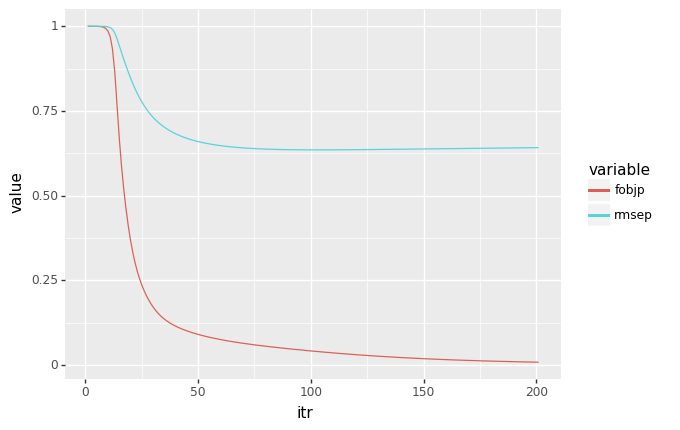

<ggplot: (-9223371946121272888)>


In [31]:
print(ggplot(path1gg, aes('itr', 'value', color = 'variable')) + geom_line())

In [32]:
# Create a rating based on time played after gradient descent
def game_hrs_density_p(pred, GAME=None, nclass=1, print_vals=True):
    game_dict = dict(games.values)
    t_GAME = GAME
    if not GAME:
        GAME = np.random.randint(0, games.shape[0])
    else:
        GAME = game_dict[GAME]
    game_data = pd.Series(pred[:, GAME])
    game_data = game_data[game_data > 0]

    # EM algorithm
    mu_init = np.linspace(min(game_data), max(game_data), nclass).reshape(-1, 1)
    sigma_init = np.array([1] * nclass).reshape(-1, 1, 1)
    gaussian = GaussianMixture(n_components=nclass, means_init=mu_init, precisions_init=sigma_init).fit(game_data.values.reshape([-1, 1]))
    if print_vals:
        print(' lambda: {}\n mean: {}\n sigma: {}\n'.format(gaussian.weights_, gaussian.means_, gaussian.covariances_))
    # building data frame for plotting
    x = np.linspace(min(game_data), max(game_data), 1000)
    dens = pd.DataFrame({'x': x})
    for i in range(nclass):
        dens['y{}'.format(i+1)] = gaussian.weights_[i]* scipy.stats.norm(gaussian.means_[i][0], gaussian.covariances_[i][0][0]).pdf(x)
    dens = dens.melt('x', value_name='gaussian')
    game_data = pd.DataFrame(game_data, columns=['game_daat'])
    game_plt = ggplot(aes(x='game_data', y='stat(density)'), game_data) + geom_histogram(bins=45, colour = "black", alpha = 0.7, size = 0.1) + \
               geom_area(dens, aes(x='x', y='gaussian', fill = 'variable'), alpha = 0.5, position = position_dodge(width=0.2)) + geom_density()+ \
               ggtitle(t_GAME)
    return game_plt

 lambda: [2.57350612e-01 6.02684735e-01 1.20509960e-01 1.89444667e-02
 5.10225954e-04]
 mean: [[ 0.86622915]
 [ 3.1956331 ]
 [ 5.32323111]
 [ 7.3511218 ]
 [10.99499374]]
 sigma: [[[0.41834057]]

 [[1.08141297]]

 [[0.65330773]]

 [[0.65291966]]

 [[0.92023095]]]



C:\Users\shrey\Anaconda3\lib\site-packages\plotnine\positions\position.py:204: PlotnineWarning: position_dodge requires non-overlapping x intervals


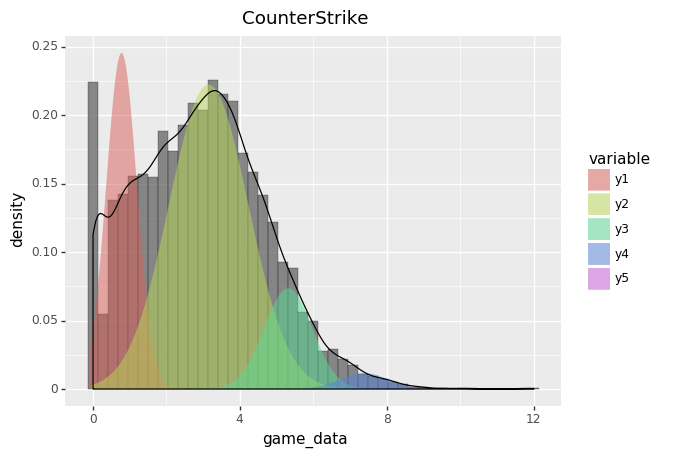

<ggplot: (-9223371946121381444)>


In [33]:
a = game_hrs_density_p(pred, "CounterStrike", 5)
print(a)

In [34]:
# Export recommend games
user_dict = dict(users.values)
game_dict = {games.iloc[i, 0]: games.iloc[i, 1] for i in range(games.shape[0])}
I_pred = np.zeros_like(I)
for i in range(steam_clean.shape[0]):
    line = steam_clean.iloc[i]
    if line['user'] in user_dict and line['game1'] in game_dict:
        I_pred[user_dict[line['user']], game_dict[line['game1']]] = 1

In [35]:
reverse_game_dict = {games.iloc[i, 1]: games.iloc[i, 0] for i in range(games.shape[0])}
pred_percentile = pd.DataFrame(pred)
for col in pred_percentile.columns:
    pred_percentile[col] = pred_percentile[col].rank(pct=True)
pred_percentile = pred_percentile.values

In [36]:
def top(n, user, print_value=True):
    #Not consider the games has been purchsed
    not_purchased = (I - 1) % 2
    t_user = user
    user = user_dict[user]
    top_games = (pred_percentile*not_purchased).iloc[user]
    top_games = list(top_games.sort_values(ascending=False)[:20].index)
    #For test
    if print_value:
        print('top {} recommended games for user {}: '.format(n, t_user))
        for i in range(n):
            print(i, ")", reverse_game_dict[top_games[i]])
    else:
        result = [t_user]
        for i in range(n):
            result.append(reverse_game_dict[top_games[i]])
        return result
top(20, 5250)

top 20 recommended games for user 5250: 
0 ) CitiesSkylines
1 ) FootballManager2015
2 ) GoatSimulator
3 ) Fallout3GameoftheYearEdition
4 ) AgeofEmpiresIIHDEdition
5 ) Terraria
6 ) TeamFortress2
7 ) MedievalIITotalWar
8 ) FootballManager2014
9 ) HalfLife2EpisodeTwo
10 ) StarTrekOnline
11 ) AmnesiaTheDarkDescent
12 ) FootballManager2012
13 ) HalfLife2
14 ) ChivalryMedievalWarfare
15 ) RedFactionGuerrillaSteamEdition
16 ) ScribblenautsUnlimited
17 ) CompanyofHeroes
18 ) Metro2033
19 ) NEOTOKYO


In [37]:
top_N = 20
result = []
users_merge=pd.merge(users_test,users_train,on='user',how='inner')
for idx, user in tqdm(enumerate(users_merge['user'].values)):
    result.append(top(top_N, user, False))

users_not=users_test[~users_test['user'].isin(users_merge['user'])]
for user in users_not['user']:
    empty=[user]
    for i in range(20):
        empty.append(0)
    result.append(empty)
df = pd.DataFrame(result)
columns = ['user_id'] + ['{}'.format(i+1) for i in range(top_N)]
df.columns = columns
df.to_csv('Collaborative_EM_output.csv')

3432it [04:30, 12.70it/s]
